In [1]:
clustering_result=['0', '1234', '5', '6']

In [2]:
import os, sys

path_name = os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from Engine.Data.IO import IO
from Engine.Pipeline.pipeline import NextoptBasePipeline,NextoptWeekdayDMPipeline,NextoptWeekdayDMProphetPipeline
from Engine.Data.IO import IO
from Engine.Data.transformer import Transformer
from Engine.Data.explorer import Explorer

# 1. Input
path_name = os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

data_dir = path_name + '/Data/DB'

df_pallets = IO.read_pickle(data_dir + '/KPP일별_발주_유형별전처리.pkl') 
# 2. Transformer
df_pallets.head()
df_pallets.transformer.dt_format = '%Y%m%d' 

df_N11 = df_pallets.transformer.get(code=['N11'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_L14 = df_pallets.transformer.get(code=['L14'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_P11 = df_pallets.transformer.get(code=['P11'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_P13= df_pallets.transformer.get(code=['P13'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_P14= df_pallets.transformer.get(code=['P14'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_set=[df_N11,df_L14,df_P11,df_P13,df_P14]

/Users/moonygo/Documents/NextoptEngine_light


SET INDEX AS DS(DateTimeIndex)
CROSS VALIDATION SPLIT IS DONE.
DIVIDE TRAIN BY WEEKDAY
DIVIDE EACH FOLD BY WEEKDAY
FOLD  1  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL


/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


FOLD  1  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  4  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  1  FIT AND FORECAST DONE
FOLD  1  DIVISION  2  FIT AND FORECAST DONE
FOLD  1  DIVISION  3  FIT AND FORECAST DONE
FOLD  1  DIVISION  4  FIT AND FORECAST DONE
MERGE DIVIDED FORECAST INTO FORECAST_TRAIN & FORECAST_TEST
POSTPROCESS YHAT = 0 IF YHAT < 0
POSTPROCESS Holiday
POSTPROCESS YHAT = 0 IF YHAT < 0
POSTPROCESS Holiday
   Fold       From         To     Real     Predict     Error  Error(%)  \
1     1 2017-12-02 2017-12-31  1438054  1490170.79 -52116.79     -3.62   

   Total Error  Total Error(%)     RMSE   MAPE  sMAPE  
1     107925.4             7.5  5064.74  18.68   7.37  
Fold  1 	 2017-12-02 00:00:00  -  2017-12-31 00:00:00


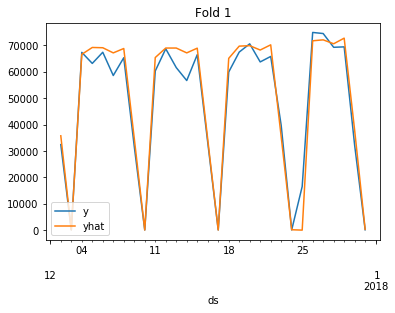

In [3]:
df = df_pallets.transformer.get(code=['N11'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2018-01-31')
df = df.fillna(0)
df = df.reset_index()
df.columns = ['ds','y']

pipeline = NextoptWeekdayDMProphetPipeline()
pipeline.raw_data = df
pipeline.horizon = 30 # 예측할 기간(defualt: 30)
pipeline.unit = 'd'

df_holiday_main = IO.read_pickle('../../Data/기타/holiday/1. 설날과추석.pkl')
df_holiday_sub = IO.read_pickle('../../Data/기타/holiday/2. 일반공휴일.pkl')
df_holiday_main['lower_window'] = 0
df_holiday_main['upper_window'] = 0
df_holiday_main['holiday'] = '중요휴일'

df_holiday_sub['lower_window'] = 0
df_holiday_sub['upper_window'] = 0
df_holiday_sub['holiday'] = '보통휴일'

df_holidays = pd.concat([df_holiday_main, df_holiday_sub])

pipeline.cross_validation_split(fold = 1)

#pipeline.division_condition = ['0','1','2','3','4','5','6'] # mon - thur, sat, sun
#pipeline.division_condition=['01234','5','6']
#pipeline.division_condition=['012345','6']
pipeline.division_condition = clustering_result
pipeline.division_condition

pipeline.model = Prophet(
        daily_seasonality= False,
        weekly_seasonality= True,
        yearly_seasonality= True,
        holidays = df_holidays
)
pipeline.fit_and_predict()
pipeline.merge_forecast()

pipeline.postprocess(holiday_correction_dict={0: df_holiday_main,
                                          0: df_holiday_sub
                                         })
pipeline.evaluate()
pipeline.print_summary()
pipeline.plot_forecast()

In [4]:
pipeline.print_summary()

   Fold       From         To     Real     Predict     Error  Error(%)  \
1     1 2017-12-02 2017-12-31  1438054  1490170.79 -52116.79     -3.62   

   Total Error  Total Error(%)     RMSE   MAPE  sMAPE  
1     107925.4             7.5  5064.74  18.68   7.37  


In [7]:
107925.4 /30

3597.5133333333333